In [1]:
# basic imports
import numpy as np

# DL imports
import torch
from einops import rearrange
from torch import nn, einsum
from functools import partial
import torch.nn.functional as F

D:\surya\miniconda37\envs\imgseg\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


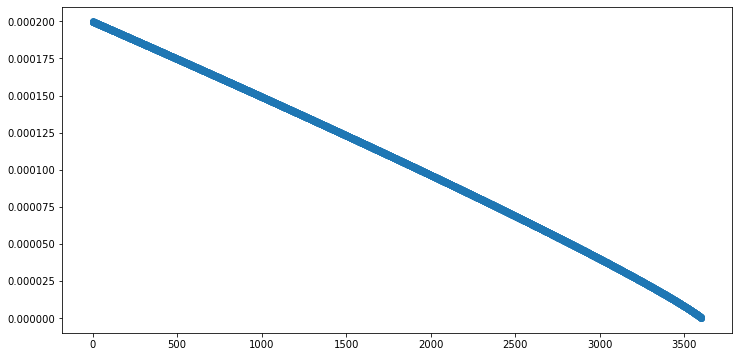

In [10]:
import matplotlib.pyplot as plt
from utils import polynomial_lr_decay

model = torch.nn.Linear(2, 1)
base_lr = 2e-4
optimizer = torch.optim.Adam(model.parameters(), lr=base_lr)
scheduler = polynomial_lr_decay(optimizer, max_decay_steps=3600, end_learning_rate=1e-8, power=0.9)

lrs = []
for i in range(3600):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

plt.figure(figsize=(12,6))
plt.plot(lrs)
plt.scatter(range(len(lrs)), lrs)    

In [3]:
# import matplotlib.pyplot as plt


# class polyLRScheduler():
#     def __init__(self, baseLR, maxSteps, power, minLR = 1e-6):
#         self.power = power
#         self.minLR = minLR
#         self.baseLR = baseLR
#         self.maxSteps = maxSteps
        
#     def getLR(self, step):
#         factor =  (1 - (step / self.maxSteps)) ** self.power
#         return (self.baseLR * factor) + self.minLR
    
# model = torch.nn.Linear(2, 1)
# polyLRSchedulerObj = polyLRScheduler(baseLR=0.01, maxSteps=3000, power=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=polyLRSchedulerObj.baseLR)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer,
#     lr_lambda=lambda step: polyLRSchedulerObj.getLR(step))

# lrs = []
# for i in range(3000):
#     optimizer.step()
#     lrs.append(optimizer.param_groups[0]["lr"])
#     scheduler.step()

# plt.figure(figsize=(12,6))
# plt.plot(lrs)
# plt.scatter(range(len(lrs)), lrs)    

In [ ]:
def cast_tuple(val, depth):
    return val if isinstance(val, tuple) else (val,) * depth

In [ ]:
class DsConv2d(nn.Module):
    def __init__(self, dim_in, dim_out, kernel_size, padding, stride = 1, bias = True):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim_in, dim_in, kernel_size = kernel_size, padding = padding, groups = dim_in, stride = stride, bias = bias),
            nn.Conv2d(dim_in, dim_out, kernel_size = 1, bias = bias)
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
# dsConvInput = torch.Tensor(2,3,180,320)
# print("dsConvInput.shape = ", dsConvInput.shape)
# model = DsConv2d(dim_in=3, dim_out=12, kernel_size=3, padding=1)
# dsConvOutput = model(dsConvInput)
# print("dsConvOutput.shape = ", dsConvOutput.shape)

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, dim, eps = 1e-5):
        super().__init__()
        self.eps = eps
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))
        self.b = nn.Parameter(torch.zeros(1, dim, 1, 1))

    def forward(self, x):
        std = torch.var(x, dim = 1, unbiased = False, keepdim = True).sqrt()
#         print("std shape = ", std.shape)
        mean = torch.mean(x, dim = 1, keepdim = True)
#         print("mean shape = ", mean.shape)
        return (x - mean) / (std + self.eps) * self.g + self.b

In [ ]:
# layerNormInput = torch.Tensor(10,3,180,320)
# print("layerNormInput.shape = " , layerNormInput.shape)
# model = LayerNorm(dim=3)
# layerNormOutput = model(layerNormInput)
# print("layerNormOutput.shape = " , layerNormOutput.shape)

In [ ]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x))

In [ ]:
class MixFeedForward(nn.Module):
    def __init__(self, *, dim, expansion_factor):
        super().__init__()
        hidden_dim = dim * expansion_factor
        self.net = nn.Sequential(
            nn.Conv2d(dim, hidden_dim, 1),
            DsConv2d(hidden_dim, hidden_dim, 3, padding = 1),
            nn.GELU(),
            nn.Conv2d(hidden_dim, dim, 1)
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
# mixFeedForwardInput = torch.Tensor(2,3,180,320)
# print("mixFeedForwardInput.shape = " , mixFeedForwardInput.shape)
# model = MixFeedForward(dim=3, expansion_factor=4)
# mixFeedForwardOutput = model(mixFeedForwardInput)
# print("mixFeedForwardOutput.shape = " , mixFeedForwardOutput.shape)

In [ ]:
class EfficientSelfAttention(nn.Module):
    def __init__(self, *, dim, heads, reduction_ratio):
        super().__init__()
        self.scale = (dim // heads) ** -0.5
        self.heads = heads

        self.to_q = nn.Conv2d(dim, dim, 1, bias = False)
        self.to_kv = nn.Conv2d(dim, dim * 2, reduction_ratio, stride = reduction_ratio, bias = False)
        self.to_out = nn.Conv2d(dim, dim, 1, bias = False)

    def forward(self, x):
        h, w = x.shape[-2:]
        heads = self.heads

        q, k, v = (self.to_q(x), *self.to_kv(x).chunk(2, dim = 1))
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> (b h) (x y) c', h = heads), (q, k, v))

        sim = einsum('b i d, b j d -> b i j', q, k) * self.scale
        attn = sim.softmax(dim = -1)

        out = einsum('b i j, b j d -> b i d', attn, v)
        out = rearrange(out, '(b h) (x y) c -> b (h c) x y', h = heads, x = h, y = w)
        return self.to_out(out)

In [ ]:
class MiT(nn.Module):
    def __init__(self, *, channels, dims, heads, ff_expansion, reduction_ratio, num_layers):
        super().__init__()
        stage_kernel_stride_pad = ((7, 4, 3), (3, 2, 1), (3, 2, 1), (3, 2, 1))

        dims = (channels, *dims)
        dim_pairs = list(zip(dims[:-1], dims[1:]))
        self.stages = nn.ModuleList([])

        for (dim_in, dim_out), (kernel, stride, padding), num_layers, ff_expansion, heads, reduction_ratio in zip(dim_pairs, stage_kernel_stride_pad, num_layers, ff_expansion, heads, reduction_ratio):
            get_overlap_patches = nn.Unfold(kernel, stride = stride, padding = padding)
            overlap_patch_embed = nn.Conv2d(dim_in * kernel ** 2, dim_out, 1)

            layers = nn.ModuleList([])

            for _ in range(num_layers):
                layers.append(nn.ModuleList([
                    PreNorm(dim_out, EfficientSelfAttention(dim = dim_out, heads = heads, reduction_ratio = reduction_ratio)),
                    PreNorm(dim_out, MixFeedForward(dim = dim_out, expansion_factor = ff_expansion)),
                ]))

            self.stages.append(nn.ModuleList([
                get_overlap_patches,
                overlap_patch_embed,
                layers
            ]))

    def forward(self, x, return_layer_outputs = False):
        h, w = x.shape[-2:]

        layer_outputs = []
        for (get_overlap_patches, overlap_embed, layers) in self.stages:
            x = get_overlap_patches(x)

            num_patches = x.shape[-1]
            ratio = int(np.sqrt((h * w) / num_patches))
            x = rearrange(x, 'b c (h w) -> b c h w', h = h // ratio)

            x = overlap_embed(x)
            for (attn, ff) in layers:
                x = attn(x) + x
                x = ff(x) + x

            layer_outputs.append(x)

        ret = x if not return_layer_outputs else layer_outputs
        return ret

In [ ]:
class Segformer(nn.Module):
    def __init__(
        self, *, dims = (32, 64, 160, 256), heads = (1, 2, 5, 8), ff_expansion = (8, 8, 4, 4),
         reduction_ratio = (8, 4, 2, 1), num_layers = 2, channels = 3, decoder_dim = 256, num_classes = 4):
        super().__init__()
        dims, heads, ff_expansion, reduction_ratio, num_layers = map(partial(cast_tuple, depth = 4), (dims, heads, ff_expansion, reduction_ratio, num_layers))
        assert all([*map(lambda t: len(t) == 4, (dims, heads, ff_expansion, reduction_ratio, num_layers))]), 'only four stages are allowed, all keyword arguments must be either a single value or a tuple of 4 values'

        self.mit = MiT(
            channels = channels,
            dims = dims,
            heads = heads,
            ff_expansion = ff_expansion,
            reduction_ratio = reduction_ratio,
            num_layers = num_layers
        )

        self.to_fused = nn.ModuleList([nn.Sequential(
            nn.Conv2d(dim, decoder_dim, 1),
            nn.Upsample(scale_factor = 2 ** i)
        ) for i, dim in enumerate(dims)])

        self.to_segmentation = nn.Sequential(
            nn.Conv2d(4 * decoder_dim, decoder_dim, 1),
            nn.Conv2d(decoder_dim, num_classes, 1),
        )

    def forward(self, x):
        h,w = x.size()[2:]
        if(((h % 32 ==0) and (w % 32 ==0)) == False):
            temp_h = round(h / 32) * 32
            temp_w = round(w / 32) * 32
            x = F.interpolate(x, (temp_h, temp_w), mode='bilinear', align_corners=False)
        
        layer_outputs = self.mit(x, return_layer_outputs = True)
        fused = [to_fused(output) for output, to_fused in zip(layer_outputs, self.to_fused)]
        fused = torch.cat(fused, dim = 1)
        decoder_output = self.to_segmentation(fused)
        return F.interpolate(decoder_output, (h,w), mode='bilinear', align_corners=False)

In [ ]:
model = Segformer(
    dims = (32, 64, 160, 256),      # dimensions of each stage
    heads = (1, 2, 4, 8),           # heads of each stage
    ff_expansion = (8, 8, 4, 4),    # feedforward expansion factor of each stage
    reduction_ratio = (8, 4, 2, 1), # reduction ratio of each stage for efficient attention
    num_layers = 2,                 # num layers of each stage
    decoder_dim = 256,              # decoder dimension
    num_classes = 3                 # number of segmentation classes
)

x = torch.randn(1, 3, 360, 640)
pred = model(x)
print(pred.shape)